In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os


from PIL import Image, ImageSequence
from scipy import ndimage as ndi
from scipy.ndimage.morphology import binary_dilation, grey_dilation
from skimage.feature import canny
import skimage.measure as measure
import cv2

In [2]:
import sys
sys.path.append('../src')
from image_segmentation import *

In [3]:
# load all pages of tiff file
tiff_dir = '../data/TimeLapse_20190517_15052019_L-algMono-0.1_tiff/'
path = tiff_dir + os.listdir(tiff_dir)[16]
all_pages = open_tiff(path)

In [4]:
path

'../data/TimeLapse_20190517_15052019_L-algMono-0.1_tiff/15052019_L-algMono-0.1_Pos9_PH_Exp001.tiff'

#### Chamber detection for first image

In [5]:
# scale pixel-values
img = all_pages[0]
img = scale_pixel_vals(img)

In [6]:
#image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img = img.astype('uint8')
enhanced = cv2.equalizeHist(img)

In [7]:
# apply dilation and find contours at a constant value
# automatic detection of color value
#dilation = grey_dilation(enhanced, size=(20,20)) #size=(20,20)
contours = measure.find_contours(enhanced, 180, fully_connected='high')

In [8]:
# closed_shape_ix = np.where([(c[:,1][0] == c[:,1][-1])&(c[:,0][0] == c[:,0][-1])\
#                             for c in contours])[0]
# closed_shapes = [contours[ix] for ix in closed_shape_ix]

# #find the rectangular contour
# x_range_contours = np.array([np.max(c[:,1]) - np.min(c[:,1]) for c in closed_shapes])
# y_range_contours = np.array([np.max(c[:,0]) - np.min(c[:,0]) for c in closed_shapes])

# #assume chamber size is above a specific value
# ix = list(set(np.where(x_range_contours > 400)[0])&set(np.where(y_range_contours > 400)[0]))

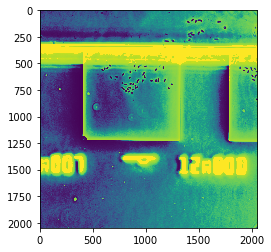

In [9]:
#plt.imshow(dilation)
#plt.plot(np.sum(dilation, axis = 1))
plt.imshow(enhanced)

True

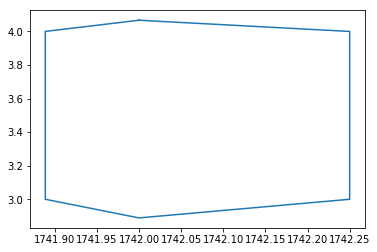

In [10]:
ix = 12
plt.plot(contours[ix][:,1], contours[ix][:,0])
(contours[ix][:,1][0] == contours[ix][:,1][-1])&(contours[ix][:,0][0] == contours[ix][:,0][-1])

In [11]:
# compute the range in x-direction for every contour and check for contours above a specific size
ix_rect = find_rectangle(contours, 700, 500)

In [12]:
# get the corners of the rectangle
corners = get_corners(contours[ix_rect])
rectangle_x, rectangle_y, range_x, range_y = draw_rectangle(corners)

corners_cut = get_corners(np.array([rectangle_y, rectangle_x]).T)
cutout = do_cutout(img, corners_cut)

Text(0.5,1,'Cutout')

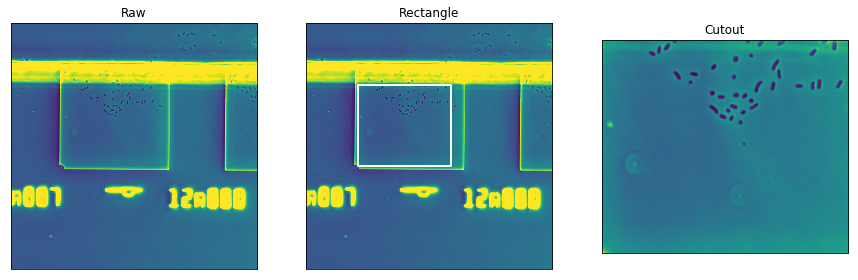

In [13]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Raw')
plt.subplot(1,3,2)
plt.imshow(img)
plt.plot(rectangle_x, rectangle_y, 'w', linewidth = 2)
plt.xticks([])
plt.yticks([])
plt.title('Rectangle')
plt.subplot(1,3,3)
plt.imshow(cutout)
plt.xticks([])
plt.yticks([])
plt.title('Cutout')

#### Chamber detection for all following images

In [14]:
# rescale pixel-values
img = all_pages[186]
img = scale_pixel_vals(img)

In [15]:
img = img.astype('uint8')
enhanced = cv2.equalizeHist(img)

In [16]:
# apply dilation and find contours at a constant value
# automatic detection of color value
#dilation = grey_dilation(enhanced, size=(20,20))
contours = measure.find_contours(enhanced, 180, fully_connected='high')

In [17]:
# x_range_contours = np.array([c[:,1] for c in contours])

# closed_rectangle_ix = np.where([c[:,1][0] == c[:,1][-1] for c in contours])[0]
# closed_rectangles = [contours[ix] for ix in closed_rectangle_ix]

# len(closed_rectangles)

In [18]:
# x_val = contours[40][:,1]
# #len(np.where(x_val == 0)[0])
# x_min_val = 0
# x_max_val = img.shape[0]
# y_min_val = 0
# y_max_val = img.shape[1]

In [19]:
# ix = 13
# plt.plot(contours[ix][:,1], contours[ix][:,0])
# (contours[ix][:,1][0] == contours[ix][:,1][-1])&(contours[ix][:,0][0] == contours[ix][:,0][-1])

In [22]:
# compute the range in x-direction for every contour and check for contours above a specific size
ix_rect = find_rectangle(contours, 700, 300)

In [23]:
# get the corners of the rectangle
corners = get_corners(contours[ix_rect])
rectangle_x, rectangle_y = draw_rectangle(corners, range_x, 
                                          range_y, first_image = False)
corners_cut = get_corners(np.array([rectangle_y, rectangle_x]).T)
cutout = do_cutout(img, corners_cut)

Text(0.5,1,'Cutout')

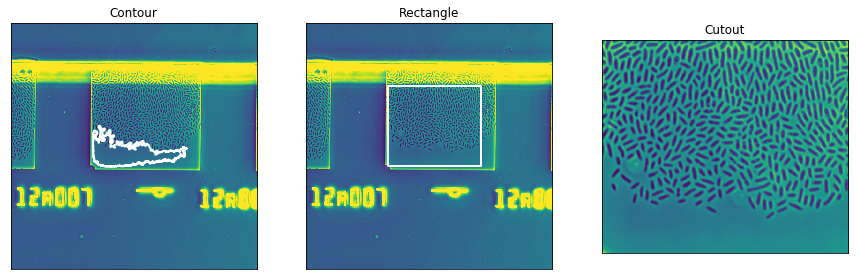

In [24]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Contour')
plt.plot(contours[ix_rect][:,1], contours[ix_rect][:,0], 'w', linewidth = 2)
plt.subplot(1,3,2)
plt.imshow(img)
plt.plot(rectangle_x, rectangle_y, 'w', linewidth = 2)
plt.xticks([])
plt.yticks([])
plt.title('Rectangle')
plt.subplot(1,3,3)
plt.imshow(cutout)
plt.xticks([])
plt.yticks([])
plt.title('Cutout')

#### Cutout all

In [ ]:
#path = tiff_dir + os.listdir(tiff_dir)[35]
all_cutouts = cutout_all_pages(path, 700, 300)


 78%|███████▊  | 155/200 [02:37<00:44,  1.02it/s]


 98%|█████████▊| 195/200 [03:17<00:05,  1.11s/it]

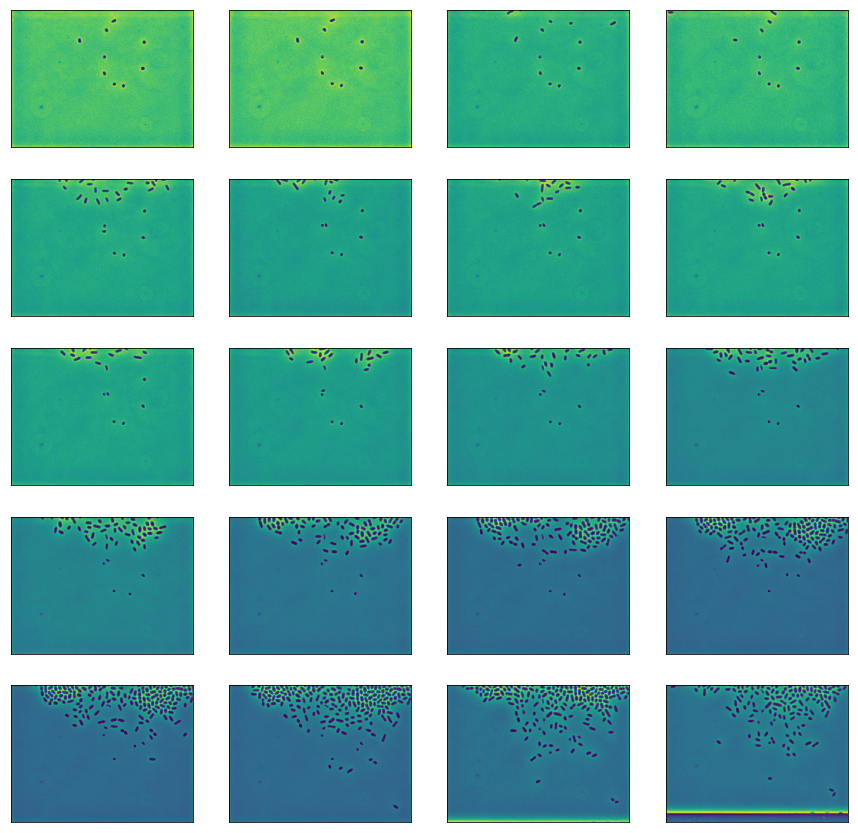

In [24]:
plt.figure(figsize = (15,15))
for i, ac in enumerate(all_cutouts[::10]):
    plt.subplot(5,4,i+1)
    plt.imshow(ac)
    plt.xticks([])
    plt.yticks([])

In [25]:
all_segmentations = []
for data in all_cutouts:
    data = data/np.max(data)
    edges = canny(data)
    all_segmentations.append(ndi.binary_fill_holes(edges))

/cluster/apps/python/3.6.1/x86_64/lib64/python3.6/site-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or


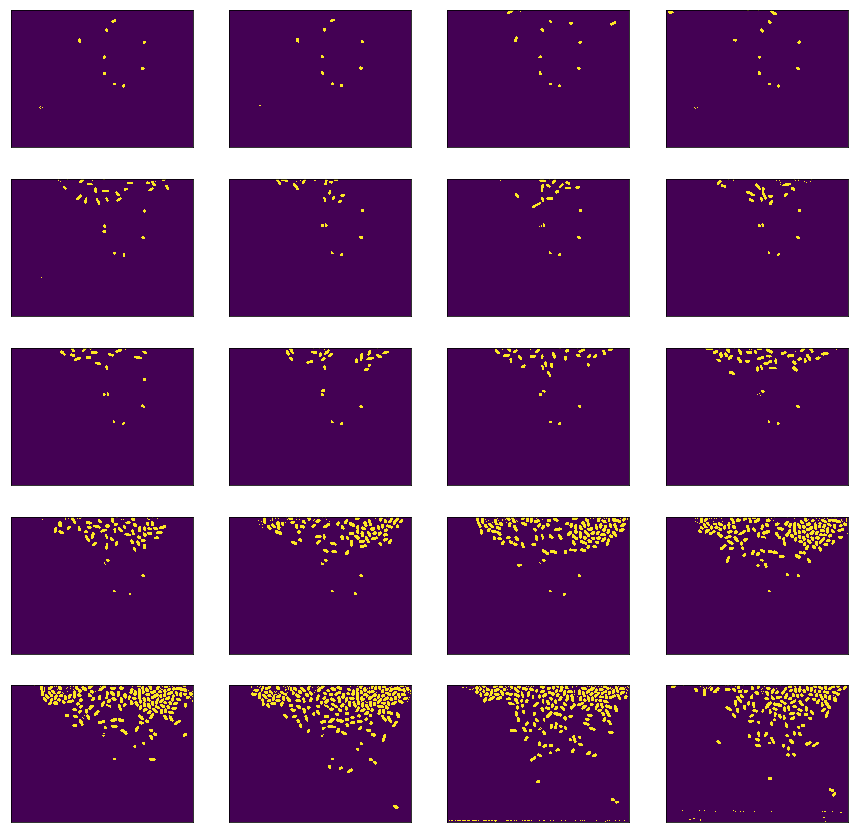

In [26]:
plt.figure(figsize = (15,15))
for i, ac in enumerate(all_segmentations[::10]):
    plt.subplot(5,4,i+1)
    plt.imshow(ac)
    plt.xticks([])
    plt.yticks([])